In [13]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict
from langchain_groq import ChatGroq
from dotenv import load_dotenv
from langgraph.checkpoint.memory import InMemorySaver

In [4]:
load_dotenv()

llm = ChatGroq(model="llama3-70b-8192")

In [6]:
class JokeState(TypedDict):
    topic: str
    joke: str
    explaination: str

In [10]:
def generate_joke(state: JokeState):
    prompt = f"Generate a joke on the topic {state['topic']}"
    response = llm.invoke(prompt).content
    return {"joke":response}

In [9]:
def generate_explaination(state: JokeState):
    prompt = f"Explain the given joke on the topic {state['topic']}\n\n Joke: f{state['joke']}"
    response = llm.invoke(prompt).content
    return {"explaination":response}

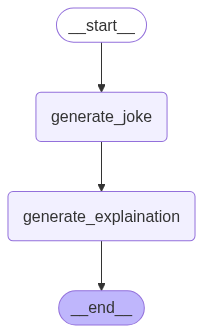

In [14]:
graph = StateGraph(JokeState)

graph.add_node("generate_joke",generate_joke)
graph.add_node("generate_explaination",generate_explaination)
graph.add_edge(START,"generate_joke")
graph.add_edge("generate_joke","generate_explaination")
graph.add_edge("generate_explaination",END)

checkpointer = InMemorySaver()
workflow = graph.compile(checkpointer=checkpointer)

workflow

In [36]:
config1 = {"configurable":{"thread_id":"1"}}
workflow.invoke({"topic":"test"},config=config1)

{'topic': 'test',
 'joke': 'Why did the test go to therapy?\n\nBecause it was feeling a little "graded" and needed to work on its "score" of self-esteem!',
 'explaination': 'A clever joke!\n\nHere\'s a breakdown of the joke:\n\nThe joke asks, "Why did the test go to therapy?" - a unexpected and humorous setup, as tests are inanimate objects and don\'t typically go to therapy.\n\nThe punchline is: "Because it was feeling a little \'graded\' and needed to work on its \'score\' of self-esteem!"\n\nThe joke relies on a play on words:\n\n* "Graded" has a double meaning here. In the context of a test, "graded" refers to the process of evaluating and assigning a score to a test-taker\'s performance. But in the context of emotions, "feeling graded" could imply feeling judged or criticized, which is a common reason people might seek therapy.\n* "Score" is another wordplay. In a test, a score refers to the numerical value assigned to a test-taker\'s performance. But in the context of self-esteem

In [37]:
workflow.get_state(config1)

StateSnapshot(values={'topic': 'test', 'joke': 'Why did the test go to therapy?\n\nBecause it was feeling a little "graded" and needed to work on its "score" of self-esteem!', 'explaination': 'A clever joke!\n\nHere\'s a breakdown of the joke:\n\nThe joke asks, "Why did the test go to therapy?" - a unexpected and humorous setup, as tests are inanimate objects and don\'t typically go to therapy.\n\nThe punchline is: "Because it was feeling a little \'graded\' and needed to work on its \'score\' of self-esteem!"\n\nThe joke relies on a play on words:\n\n* "Graded" has a double meaning here. In the context of a test, "graded" refers to the process of evaluating and assigning a score to a test-taker\'s performance. But in the context of emotions, "feeling graded" could imply feeling judged or criticized, which is a common reason people might seek therapy.\n* "Score" is another wordplay. In a test, a score refers to the numerical value assigned to a test-taker\'s performance. But in the con

In [38]:
#See intermediate state history
list(workflow.get_state_history(config1))

[StateSnapshot(values={'topic': 'test', 'joke': 'Why did the test go to therapy?\n\nBecause it was feeling a little "graded" and needed to work on its "score" of self-esteem!', 'explaination': 'A clever joke!\n\nHere\'s a breakdown of the joke:\n\nThe joke asks, "Why did the test go to therapy?" - a unexpected and humorous setup, as tests are inanimate objects and don\'t typically go to therapy.\n\nThe punchline is: "Because it was feeling a little \'graded\' and needed to work on its \'score\' of self-esteem!"\n\nThe joke relies on a play on words:\n\n* "Graded" has a double meaning here. In the context of a test, "graded" refers to the process of evaluating and assigning a score to a test-taker\'s performance. But in the context of emotions, "feeling graded" could imply feeling judged or criticized, which is a common reason people might seek therapy.\n* "Score" is another wordplay. In a test, a score refers to the numerical value assigned to a test-taker\'s performance. But in the co

In [77]:
#Testing Fault Tolerance
import time

In [ ]:
def generate_joke(state: JokeState):
    prompt = f"Generate a joke on the topic {state['topic']}"
    response = llm.invoke(prompt).content
    print("JOKE DONE")
    return {"joke":response}

In [74]:
def generate_explaination(state: JokeState):
    time.sleep(10)
    prompt = f"Explain the given joke on the topic {state['topic']}\n\n Joke: f{state['joke']}"
    response = llm.invoke(prompt).content
    return {"explaination":response}

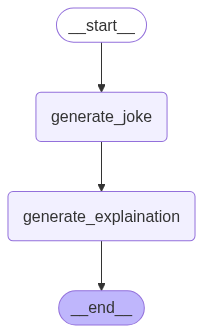

In [75]:
graph = StateGraph(JokeState)

graph.add_node("generate_joke",generate_joke)
graph.add_node("generate_explaination",generate_explaination)
graph.add_edge(START,"generate_joke")
graph.add_edge("generate_joke","generate_explaination")
graph.add_edge("generate_explaination",END)

checkpointer = InMemorySaver()
workflow = graph.compile(checkpointer=checkpointer)

workflow

In [78]:
config2 = {"configurable":{"thread_id":1}}
workflow.invoke({"topic":"Cricket"},config=config2)

KeyboardInterrupt: 

In [80]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'Cricket', 'joke': 'Why did the cricket go to the doctor?\n\nBecause it had a "sticky wicket" situation! (get it? Sticky wicket, like a tricky situation in cricket, but also a play on words for a medical issue)'}, next=('generate_explaination',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07204e-f0e6-6aa3-8004-9b5389f6b905'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}, 'thread_id': 1}, created_at='2025-08-05T14:03:16.462045+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07204e-eba8-618c-8003-16489ffe9659'}}, tasks=(PregelTask(id='53f1f9e4-148a-92a1-6d74-7ec13c1a62f2', name='generate_explaination', path=('__pregel_pull', 'generate_explaination'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [84]:
print(workflow.invoke(None,config=config2))

{'topic': 'Cricket', 'joke': 'Why did the cricket go to the doctor?\n\nBecause it had a "sticky wicket" situation! (get it? Sticky wicket, like a tricky situation in cricket, but also a play on words for a medical issue)', 'explaination': 'A clever cricket joke!\n\nThe joke is a play on words, using a phrase commonly associated with the sport of cricket to create a pun. Here\'s how it works:\n\nIn cricket, a "sticky wicket" refers to a difficult or challenging situation on the field, particularly when the pitch (the surface where the game is played) is damp or wet, making it hard for the batsmen to play their shots. It\'s a metaphorical expression used to describe a tricky or precarious situation in the game.\n\nIn the joke, the phrase "sticky wicket" is used to describe a medical issue that the cricket (the insect) is experiencing. The wordplay comes from the fact that "sticky" can also imply a medical condition that\'s sticky or hard to get rid of, like a sticky patch on the skin or 

In [98]:
print(workflow.invoke({"topic":"Cricket"},config=config2))

{'topic': 'Cricket', 'joke': 'Why did the cricket go to the doctor?\n\nBecause it had a "sticky wicket" situation!', 'explaination': 'A cricket joke!\n\nHere\'s a breakdown of the joke:\n\nIn cricket, a "sticky wicket" is a term used to describe a difficult situation for the batsmen (the players who hit the ball). It refers to a wet and uneven pitch (the playing surface) that makes it hard for them to score runs. In this context, a "sticky wicket" is a challenging circumstance.\n\nNow, let\'s look at the joke:\n\n"Why did the cricket go to the doctor?"\n\nThe setup is simple: a cricket, the insect, goes to see a doctor.\n\nThe punchline:\n\n"Because it had a \'sticky wicket\' situation!"\n\nThe joke relies on a play on words. In cricket, a "sticky wicket" is a specific term with a specific meaning. Here, the joke uses that term to create a pun. The cricket (the insect) goes to the doctor because it has a "sticky wicket situation," implying that the cricket is in a difficult or tricky s

In [99]:
list(workflow.get_state(config2))

[{'topic': 'Cricket',
  'joke': 'Why did the cricket go to the doctor?\n\nBecause it had a "sticky wicket" situation!',
  'explaination': 'A cricket joke!\n\nHere\'s a breakdown of the joke:\n\nIn cricket, a "sticky wicket" is a term used to describe a difficult situation for the batsmen (the players who hit the ball). It refers to a wet and uneven pitch (the playing surface) that makes it hard for them to score runs. In this context, a "sticky wicket" is a challenging circumstance.\n\nNow, let\'s look at the joke:\n\n"Why did the cricket go to the doctor?"\n\nThe setup is simple: a cricket, the insect, goes to see a doctor.\n\nThe punchline:\n\n"Because it had a \'sticky wicket\' situation!"\n\nThe joke relies on a play on words. In cricket, a "sticky wicket" is a specific term with a specific meaning. Here, the joke uses that term to create a pun. The cricket (the insect) goes to the doctor because it has a "sticky wicket situation," implying that the cricket is in a difficult or tri

In [90]:
print(workflow.invoke(None,config=config2))

{'topic': 'test', 'joke': 'Why did the test go to therapy?\n\nBecause it was feeling a little "graded" and needed to work through some "multiple" issues', 'explaination': 'A clever play on words!\n\nThis joke is a pun on words related to tests and therapy. Here\'s a breakdown:\n\n* "Graded" has a double meaning:\n\t+ In the context of tests, "graded" refers to the process of evaluating and assigning a score or grade to a student\'s performance.\n\t+ In a therapy context, "feeling graded" is a wordplay on "feeling judged" or "feeling criticized," implying that the test is feeling self-conscious or anxious about its own performance.\n* "Multiple" issues is another clever play on words:\n\t+ In the context of tests, "multiple" often refers to multiple-choice questions, where a student is presented with several options to choose from.\n\t+ In a therapy context, "multiple issues" means that the test has various problems or concerns that it needs to work through with the therapist.\n\nSo, th

In [92]:
list(workflow.get_state(config2))

[{'topic': 'test',
  'joke': 'Why did the test go to therapy?\n\nBecause it was feeling a little "graded" and needed to work through some "multiple" issues',
  'explaination': 'A clever play on words!\n\nThis joke is a pun on words related to tests and therapy. Here\'s a breakdown:\n\n* "Graded" has a double meaning:\n\t+ In the context of tests, "graded" refers to the process of evaluating and assigning a score or grade to a student\'s performance.\n\t+ In a therapy context, "feeling graded" is a wordplay on "feeling judged" or "feeling criticized," implying that the test is feeling self-conscious or anxious about its own performance.\n* "Multiple" issues is another clever play on words:\n\t+ In the context of tests, "multiple" often refers to multiple-choice questions, where a student is presented with several options to choose from.\n\t+ In a therapy context, "multiple issues" means that the test has various problems or concerns that it needs to work through with the therapist.\n\nS

In [93]:
#TIME TRAVEL

In [96]:
workflow.get_state(config2)

StateSnapshot(values={'topic': 'test', 'joke': 'Why did the test go to therapy?\n\nBecause it was feeling a little "graded" and needed to work through some "multiple" issues', 'explaination': 'A clever play on words!\n\nThis joke is a pun on words related to tests and therapy. Here\'s a breakdown:\n\n* "Graded" has a double meaning:\n\t+ In the context of tests, "graded" refers to the process of evaluating and assigning a score or grade to a student\'s performance.\n\t+ In a therapy context, "feeling graded" is a wordplay on "feeling judged" or "feeling criticized," implying that the test is feeling self-conscious or anxious about its own performance.\n* "Multiple" issues is another clever play on words:\n\t+ In the context of tests, "multiple" often refers to multiple-choice questions, where a student is presented with several options to choose from.\n\t+ In a therapy context, "multiple issues" means that the test has various problems or concerns that it needs to work through with the

In [101]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'Cricket', 'joke': 'Why did the cricket go to the doctor?\n\nBecause it had a "sticky wicket" situation!', 'explaination': 'A cricket joke!\n\nHere\'s a breakdown of the joke:\n\nIn cricket, a "sticky wicket" is a term used to describe a difficult situation for the batsmen (the players who hit the ball). It refers to a wet and uneven pitch (the playing surface) that makes it hard for them to score runs. In this context, a "sticky wicket" is a challenging circumstance.\n\nNow, let\'s look at the joke:\n\n"Why did the cricket go to the doctor?"\n\nThe setup is simple: a cricket, the insect, goes to see a doctor.\n\nThe punchline:\n\n"Because it had a \'sticky wicket\' situation!"\n\nThe joke relies on a play on words. In cricket, a "sticky wicket" is a specific term with a specific meaning. Here, the joke uses that term to create a pun. The cricket (the insect) goes to the doctor because it has a "sticky wicket situation," implying that the cricket is in a

In [103]:
config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f07204e-93bd-6a11-8001-9c7e262277e1'}}
workflow.invoke(None,{"configurable":{"thread_id":1,"checkpoint_id":"1f07204e-93bd-6a11-8001-9c7e262277e1"}})

{'topic': 'Cricket',
 'joke': 'Here\'s one:\n\nWhy did the cricket go to the doctor?\n\nBecause it had a "sticky" wicket! (get it? like a sticky situation, but also a reference to the wicket in cricket!)\n\nHope that one hit a six with you!',
 'explaination': 'A cricket joke!\n\nThe joke is a play on words, using a common phrase "sticky situation" and giving it a cricket twist.\n\nIn cricket, a wicket refers to the three stumps (vertical poles) and two bails (small pieces of wood) placed at each end of the pitch. A "sticky wicket" is a term used to describe a wicket that is difficult to bat on, often due to damp or uneven conditions, making it challenging for the batsman to score runs.\n\nIn this joke, the punchline "it had a \'sticky\' wicket" is a pun. Instead of referring to the cricketing term, it\'s using the phrase "sticky situation" to imply that the cricket (the insect) is in a tricky or difficult situation, hence it needs to visit a doctor. The wordplay is what makes the joke 

In [104]:
workflow.invoke(None,{"configurable":{"thread_id":1,"checkpoint_id":"1f07204e-93bd-6a11-8001-9c7e262277e1"}})

{'topic': 'Cricket',
 'joke': 'Here\'s one:\n\nWhy did the cricket go to the doctor?\n\nBecause it had a "sticky" wicket! (get it? like a sticky situation, but also a reference to the wicket in cricket!)\n\nHope that one hit a six with you!',
 'explaination': 'A cricket joke!\n\nThe joke is a play on words, using a pun to create humor. Here\'s a breakdown:\n\n**Setup:** "Why did the cricket go to the doctor?" - This is a classic joke setup, implying that something is wrong with the cricket.\n\n**Punchline:** "Because it had a \'sticky\' wicket!" - This is where the wordplay happens. In cricket, a "wicket" refers to the set of three stumps and two bails at each end of the pitch. A "sticky wicket" is a specific type of wicket that is damp and difficult to bat on, making it challenging for the batsman.\n\nIn this joke, "sticky wicket" has a double meaning:\n\n1. In cricket, a sticky wicket is a difficult situation for the batsman.\n2. In everyday language, "sticky situation" means a probl

In [105]:
list(workflow.get_state_history(config2))

[StateSnapshot(values={'topic': 'Cricket', 'joke': 'Here\'s one:\n\nWhy did the cricket go to the doctor?\n\nBecause it had a "sticky" wicket! (get it? like a sticky situation, but also a reference to the wicket in cricket!)\n\nHope that one hit a six with you!', 'explaination': 'A cricket joke!\n\nThe joke is a play on words, using a pun to create humor. Here\'s a breakdown:\n\n**Setup:** "Why did the cricket go to the doctor?" - This is a classic joke setup, implying that something is wrong with the cricket.\n\n**Punchline:** "Because it had a \'sticky\' wicket!" - This is where the wordplay happens. In cricket, a "wicket" refers to the set of three stumps and two bails at each end of the pitch. A "sticky wicket" is a specific type of wicket that is damp and difficult to bat on, making it challenging for the batsman.\n\nIn this joke, "sticky wicket" has a double meaning:\n\n1. In cricket, a sticky wicket is a difficult situation for the batsman.\n2. In everyday language, "sticky situ